In [220]:
import numpy as np
from scipy.stats import norm
from numpy import genfromtxt
import time
np.random.seed(211)
import os
t_start = time.time()
N = 16
modulation=3       # Defines the matrix S defined in (3) of paper, 1- Identity, 2- ZC, 3- DFT 
SNR=0               # SNR of measurements
algo=1              # 1- Projected Gradient ascent, 2- Franke Wolfe
nuc_norm_bd=20.1      # estimate this from channel data- Verified this to be ~16
Nrandom_init=5      # Set to 1 to GET A ROUGH IDEA, For final plot use 5
Nchan=100           # No. of channels; Used 1 here for illustration, paper uses 100 channels
like_it=[]    
def DFT_matrix(N):
    x, y = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp(-2*1j*np.pi/N)
    W = np.power(omega,x*y)/np.sqrt(N)
    return W

if(modulation==1): 
    Z_code=np.eye(N,dtype=complex)
if(modulation==2): 
    zcbase=np.pi*11*(np.arange(N)**2)/N
    zcbase=np.exp(1j*zcbase)/np.sqrt(N)                 
    Z_code=np.zeros([N,N],dtype=complex)
    for zz in range(N):
        Z_code[:,zz]=np.roll(zcbase, zz)
if(modulation==3):
    Z_code=DFT_matrix(N)
    
def compute_channel(ch):                           # load channel data
    path = os.getcwd()+ "/NYU_raw_data/Non_LoS_38GHz_UMi_16x16_15m/"
    CH_real=genfromtxt(path + 'Real_H_'+str(ch+1)+'.csv', delimiter=',')
    CH_imag=genfromtxt(path + 'Imag_H_'+str(ch+1)+'.csv', delimiter=',')
    CH=CH_real+1j*CH_imag
    return CH

def fx(value, s):                # used to compute Likelihood and its gradient
    return norm.cdf(value*1.0/s)

def fxprime(value, s):           # used to compute gradient of the likelihood
    curr = value*1.0/s
    return norm.pdf(curr)/s

def nucnorm_ball_projection(A):  # nuclear norm ball projection step
    U, S, V = np.linalg.svd(A, full_matrices=False)
    S = simplex(S)
    return U.dot(np.diag(S).dot(V))
def L2_ball_projection(A):  # nuclear norm ball projection step
    B=A*1.0/np.linalg.norm(A,'fro');
    return B
def powmethod(A,N):              # power iteration method to compute top singular vectors
    vg=np.random.randn(N,)+1j*np.random.randn(N,)
    for nn in range(10):
        Ah=A.conj().T
        vg=Ah.dot(A.dot(vg))
    vg=vg/np.linalg.norm(vg)
    ug=A.dot(vg)
    ug=ug/np.linalg.norm(ug)
    return np.outer(ug,vg.conj())
    
def simplex(y):                 # simplex projection step used in projected gradient ascent
    u=np.sort(y)[::-1]
    cs=np.cumsum(u)
    ncs=1.0-1.0*cs
    indx=np.linspace(1,np.size(u),np.size(u),endpoint=True)
    sr=ncs/indx
    srs=sr+u
    rho=np.max(np.where(srs>0))
    lb=sr[rho]
    x=y+lb
    x[x<0]=0
    return x

def Likel(x,y,o,s,num):       # Likelihood function, here o represents the set of phase offsets defined in Sec. 3.4
    sumll=0
    for i in range(num):      # num is the number of phase offsets, i.e., B in our paper
        xr = (x.real * np.cos(o[i])) - (x.imag * np.sin(o[i]))
        xi = (x.imag * np.cos(o[i])) + (x.real * np.sin(o[i]))
        LYR=np.where(y[i].real > 0, np.log10(fx(xr,s)),0)+np.where(y[i].real < 0, np.log10(1-fx(xr,s)),0)
        LYI=np.where(y[i].imag > 0, np.log10(fx(xi,s)),0)+np.where(y[i].imag < 0, np.log10(1-fx(xi,s)),0)
        sumll=sumll+np.sum(LYR+LYI)
    return sumll             # Likelihood function for the phase offset-based training.
# For the special case when o contains a single element zero, the likelihood expression is same as (8) in our paper.

def Gradient(x, y, o, s,num):  # Gradient of the likelihood function
    grad = []
    for i in range(num):  
        xr = (x.real * np.cos(o[i])) - (x.imag * np.sin(o[i]))
        xi = (x.imag * np.cos(o[i])) + (x.real * np.sin(o[i]))
        zrr = np.where(y[i].real > 0, ((1 / fx(xr, s)) * fxprime(xr, s) * np.cos(o[i])), 0) + np.where(y[i].real < 0, (
                    (1 / (1 - fx(xr, s))) * -1 * fxprime(xr, s) * np.cos(o[i])), 0)
        zri = np.where(y[i].real > 0, ((1 / fx(xr, s)) * fxprime(xr, s) * -1 * np.sin(o[i])), 0) + np.where(y[i].real < 0, (
                    (1 / (1 - fx(xr, s))) * -1 * fxprime(xr, s) * -1 * np.sin(o[i])), 0)
        zir = np.where(y[i].imag > 0, ((1 / fx(xi, s)) * fxprime(xi, s) * np.sin(o[i])), 0) + np.where(y[i].imag < 0, (
                    (1 / (1 - fx(xi, s))) * -1 * fxprime(xi, s) * np.sin(o[i])), 0)
        zii = np.where(y[i].imag > 0, ((1 / fx(xi, s)) * fxprime(xi, s) * np.cos(o[i])), 0) + np.where(y[i].imag < 0, (
                    (1 / (1 - fx(xi, s))) * -1 * fxprime(xi, s) * np.cos(o[i])), 0)
        grad.append((zrr + (1j * zri)) + (zir + (1j * zii)))
    return sum(grad)
    
def solve(Y_in,N,norm_bd,ang_set,sig,algo,num):
    like_it=[];
    if(algo==1):  # Projected gradient ascent
        X_t = np.random.randn(N, N) + 1j * np.random.randn(N, N)
        U, s, V = np.linalg.svd(X_t, full_matrices=False)
        s = s * norm_bd / np.sum(s)
        X_t = U.dot(np.diag(s).dot(V))
       # X_t = np.random.randn(N, N) + 1j * np.random.randn(N, N)
        LLprev=Likel(X_t,Y_in,ang_set,sig,num)
        for t in range(80):
            gamma_t = 1/num
            Grad = Gradient(X_t, Y_in, ang_set, sig,num)
            X_prev=X_t
            X_t=X_t+gamma_t*Grad 
            X_t = norm_bd * nucnorm_ball_projection(X_t / norm_bd)
            LLnew=Likel(X_t,Y_in,ang_set,sig,num)
            stpcriterion=(LLnew-LLprev)/np.abs(LLprev)
            LLprev=LLnew
            like_it.append(LLnew)
            if((stpcriterion<1e-10) & (stpcriterion>0)):
                break
            if((stpcriterion<0)):
                gamma_t=gamma_t*0.5
                X_t=X_prev
    if(algo==2):  #Franke Wolfe
        X_t=np.random.randn(N, N) + 1j * np.random.randn(N, N)#np.zeros([N,N],dtype=complex)  
        U, s, V = np.linalg.svd(X_t, full_matrices=False)
        s = s * norm_bd / np.sum(s)
        X_t = U.dot(np.diag(s).dot(V))
        LLprev=Likel(X_t,Y_in,ang_set,sig,num)
        cfac=2;
        for t in range(80):
            gamma_t = cfac / (t + 2)
            Grad = Gradient(X_t, Y_in, ang_set, sig,num)
            X_prev=X_t
            X_t = X_t + (gamma_t * (norm_bd*powmethod(Grad,N)-X_t))
            LLnew=Likel(X_t,Y_in,ang_set,sig,num)
            stpcriterion=(LLnew-LLprev)/np.abs(LLprev)
            LLprev=LLnew
            like_it.append(LLnew)
            if((stpcriterion<1e-10) & (stpcriterion>0)):
                break
            if((stpcriterion<0)):
                cfac=cfac*0.5
                X_t=X_prev
    return X_t,like_it

for algo in range(1,3):
    NMSEvec=[]
    Transvec=[8,16,32,48,64,80,96];        # Vector containing number of transmissions(Np);Paper uses [8,16,32,48,64,80,96];
    for ttv in range(len(Transvec)):
        Trans=Transvec[ttv]            # PARAMETER 1- N_p
        B = Trans*N
        blocks = B // N**2
        sblocks = (B - (blocks*N**2)) / N
        sblocks = int(sblocks)
        num = blocks + 1
        omega = []
        for i in range(num):
            omega.append(i*(np.pi/(2*num)))
        scaling_ch=1
        sigma=10**(-SNR/20)
        sigma_model=max(0.5,sigma)
        arr = []
        Ys = []
        print(ttv)
        for ch in range(Nchan):
            H=compute_channel(ch) 
            Hmod=H.dot(Z_code)        # Hmod is the transformed channel, i.e., G defined in paper
            H_ts = []
            for i in range(Nrandom_init):
                np.random.seed(21 * i)
                M=Hmod*scaling_ch
                Ys = []
                for indw in range(len(omega)):
                    w=omega[indw]
                    Noise_blk=sigma*(np.random.randn(N,N)+1j*np.random.randn(N,N))/np.sqrt(2) 
                    Y = np.sign((M.real * np.cos(w)) - (M.imag * np.sin(w))+Noise_blk.real) + 1j*(np.sign((M.imag * np.cos(w)) + (M.real * np.sin(w))+Noise_blk.imag))
                    if indw == len(omega)-1:
                        k = np.random.choice(N, size=N - sblocks, replace=False)
                        Y[:, k] = 0
                    Ys.append(Y)
                X_t,like_it=solve(Ys,N,nuc_norm_bd,omega,sigma_model,algo,num) 
                H_t=X_t.dot(np.conj(Z_code))             # Invert the transformation between H and G to get back H.
                norm_sq_H = np.linalg.norm(H, 'fro') ** 2
                alph = np.sum(np.conj(H_t) * H) / np.sum(np.conj(H_t) * H_t)
                NMSE = (np.linalg.norm(H - alph * H_t, 'fro') ** 2) / norm_sq_H
                arr.append(NMSE)
                H_t = np.reshape(H_t, (256))
                H_ts.append(H_t)
            dirName = "SNR_0" +"_Trans_"+str(Trans)+"/"
            try:
                os.makedirs(dirName)
              #  print("Directory ", dirName, " Created ")
            except FileExistsError:
                testprint=0;
    #            print("Directory ", dirName, " already exists")
            filename = "estim_channel_no_" + str(ch) + "_algo_" + str(algo) + ".csv"
            #save_path = "Users/nm27265-admin/Downloads/Low-rank-MIMO-channel-estimation-from-one-bit-measurements-master/" + dirName + filename
            np.savetxt(dirName + filename, (H_ts), fmt="%f")
        print(10*np.log10(sum(arr)/Nrandom_init/Nchan))
        print("NMSE =")
        NMSEvec.append(10*np.log10(sum(arr)/Nrandom_init/Nchan))
    elapsed = time.time() - t_start
    print("Elapsed time =")
    print(elapsed)


0
-0.37276133578677784
NMSE =
1
-0.9775649855946316
NMSE =
2
-2.024698373373976
NMSE =
3
-2.802382461898909
NMSE =
4
-3.546734519655073
NMSE =
5
-4.20435843932944
NMSE =
6
-4.7419814324595935
NMSE =
Elapsed time =
779.7234029769897
0
-0.37031411608079756
NMSE =
1
-0.9580420069735618
NMSE =
2
-1.9678885678719253
NMSE =
3
-2.7379280539583677
NMSE =
4
-3.475182991321344
NMSE =
5
-4.126964506588981
NMSE =
6
-4.662160531536175
NMSE =
Elapsed time =
2899.560033082962


In [202]:
algo

1

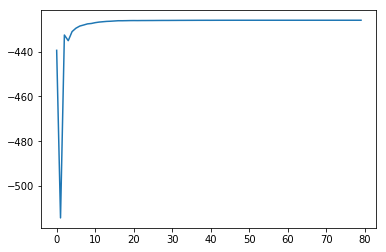

In [195]:
import matplotlib.pyplot as plt
plt.plot(like_it)

In [ ]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
angle_rx = np.arange(N)
angle_tx = np.arange(N)
angle_rx, angle_tx = np.meshgrid(angle_rx, angle_tx)
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
Spec_true = np.abs(np.fft.fft2(H))

# Plot the surface.
surf = ax.plot_surface(angle_rx, angle_tx, Spec_true, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.title('True channel Angle spectrum')
plt.xlabel('DFT direction (RX)')
plt.ylabel('DFT direction (TX)')
plt.show()
print("\n ")
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
Spec = np.abs(np.fft.fft2(X_t))

# Plot the surface.
surf = ax.plot_surface(angle_rx, angle_tx, Spec, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,)
plt.title('Estimated channel Angle spectrum')
plt.xlabel('DFT direction (RX)')
plt.ylabel('DFT direction (TX)')
plt.show()

In [6]:
np.linalg.norm(H,'fro')

16.000037794842463

In [219]:
for i in range(1,3):
    print(i)

1
2


In [56]:
a=np.random.randn(4,4)+1j*np.random.randn(4,4)
b=np.random.randn(4,4)+1j*np.random.randn(4,4)

In [217]:
range(2)

range(0, 2)

In [61]:
np.conjugate(b)

array([[ 0.06749226-0.59690648j,  0.01633808+0.98728669j,
         0.28431452+0.40123471j,  0.41540063+0.80008248j],
       [-1.03148246+1.0431295 j, -1.42999126+0.85707819j,
        -0.06163805-0.67746217j, -1.43273549-0.05182039j],
       [ 0.08753147+0.87916063j,  0.93874688+0.23110161j,
         0.60711167+1.63880731j, -1.04817041+0.73331281j],
       [-0.86026245-2.14957453j,  0.3283013 +0.09024385j,
        -0.40129781-0.73165893j, -0.3166553 +0.06548838j]])

In [163]:
a=0.1
if((a>0) & (a<2)):
    print(a)

0.1
